<a href="https://colab.research.google.com/github/Jay101291/Healthcare-Data-New/blob/main/Healthcare_Premium_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
pip install xgboost

In [107]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [108]:
df = pd.read_excel("/content/premiums_with_life_style.xlsx")

In [109]:
df.head()

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [110]:
# Preprocessing
df.columns = df.columns.str.replace(" ","_").str.lower()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [111]:
# Outlier Treatment
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [112]:
# Data cleanup and transformations
df1 = df[df['age'] <= 100]
quantile_threshold = df1['income_lakhs'].quantile(0.999)
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
dependant_threshold = df2['number_of_dependants'].quantile(0.99)
df3 = df2[df2['number_of_dependants'] <= dependant_threshold]

In [113]:
# Ensure df3 is explicitly a copy
df3 = df2[df2['number_of_dependants'] <= dependant_threshold].copy()

# Modify 'insurance_plan' column safely
df3.loc[:, 'insurance_plan'] = df3['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

# Modify 'income_level' column safely
df3.loc[:, 'income_level'] = df3['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})

In [114]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3, columns=nominal_cols, drop_first=True, dtype=int)

In [115]:
# Check which columns are present in df4
available_columns = df4.columns

# Define columns to drop (only those present in df4)
columns_to_drop = [col for col in ['medical_history', 'disease1', 'disease2', 'total_risk_score', 'physical_activity', 'stress_level'] if col in available_columns]

# Drop the columns that exist
df5 = df4.drop(columns=columns_to_drop, axis=1)

In [116]:
# VIF Calculation
X = df5.drop('annual_premium_amount', axis='columns')
y = df5['annual_premium_amount']

In [117]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [118]:
# Drop columns with high VIF
X_reduced = X.drop('income_level', axis="columns")

In [119]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

In [120]:
# Scaling
# Check available columns in X_train
available_columns = X_train.columns

# Filter the columns to scale to only those present in X_train
cols_to_scale = [col for col in ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'lifestyle_risk_score'] if col in available_columns]

# Scale only the existing columns
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [121]:
# Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [122]:
# Evaluate Linear Regression
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(f"Linear Regression ==> MSE: {mse_lr}")

Linear Regression ==> MSE: 7467589.830170783


In [123]:
pip install --upgrade xgboost scikit-learn

In [124]:
# XGBoost
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [125]:
!pip install -U scikit-learn


In [126]:
# Hyperparameter Tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_xgb,
    param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=1  # Disable parallel processing
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [127]:
# Evaluate XGBoost
best_model = random_search.best_estimator_

In [128]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_xgb,
    param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=1  # Avoid serialization issues
)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_


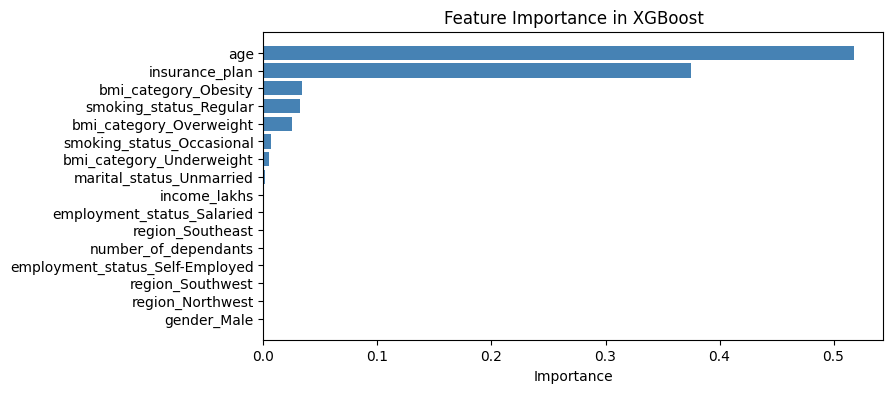

In [129]:
# Plot feature importance
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Importance'])
coef_df = coef_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

In [130]:
!pip install streamlit

In [131]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib  # For loading pre-trained models

# Load Pre-trained Model and Scaler
model = joblib.load("xgb_model.pkl")  # Replace with actual path to your model
scaler = joblib.load("scaler.pkl")  # Replace with actual path to your scaler

# Streamlit App
st.title("Insurance Premium Prediction App")
st.sidebar.header("Upload Your Dataset")

# File Upload
uploaded_file = st.sidebar.file_uploader("Upload an Excel file", type=["xlsx"])

if uploaded_file is not None:
    df = pd.read_excel(uploaded_file)
    st.write("Uploaded Dataset")
    st.dataframe(df.head())

    # Preprocessing
    df.columns = df.columns.str.replace(" ", "_").str.lower()
    df['insurance_plan'] = df['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
    df['income_level'] = df['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})

    nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
    df = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)

    cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'lifestyle_risk_score']
    df[cols_to_scale] = scaler.transform(df[cols_to_scale])

    # Prediction
    predictions = model.predict(df)
    df['Predicted_Annual_Premium'] = predictions
    st.write("Predicted Premiums")
    st.dataframe(df[['Predicted_Annual_Premium']])

else:
    st.write("Please upload a dataset to proceed.")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501
y



⠙⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8504
  Network URL: http://172.28.0.12:8504
  External URL: http://34.150.164.64:8504

⠦⠧your url is: https://silent-mails-sell.loca.lt
